# Large-scale Graph Statistics of Multiverse Galaxies

In [1]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
from pyspark import SparkContext   
from pyspark.sql import SQLContext

#sc = SparkContext(master='local[3]', appName='calgraph')
sqlsc = SQLContext(sc)
#sc.setCheckpointDir("./checkpoints")
#sc.setCheckpointDir("hdfs://localhost:8020/myhdfs/spark/checkpoints")
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row

## Read the csv file directly using sqlsc.read.csv and appropriate schema

In [3]:
halo_schema = T.StructType([\
                           T.StructField('haloid', T.IntegerType(), False),\
                           T.StructField('px', T.FloatType(), False),\
                           T.StructField('py', T.FloatType(), False),\
                           T.StructField('pz', T.FloatType(), False),\
                           T.StructField('halomass', T.FloatType(), False),\
                          ])

In [28]:
halodf = sqlsc.read.csv("hdfs://master:54310/data/spark/multiverse/omp31/sub0.csv",\
                      header=True, schema = halo_schema)

In [29]:
halodf.cache()
sys.getsizeof(halodf)

64

In [30]:
halodf.show(5,truncate=True)

+--------+---------+---------+---------+-------------+
|  haloid|       px|       py|       pz|     halomass|
+--------+---------+---------+---------+-------------+
| 5188409|296.45267|189.95506|191.31058|4.17597992E14|
|10821661|417.54764|440.56128|346.05518|2.48312997E14|
| 9996014|170.42914|399.26718|59.763397| 5.9249598E13|
| 9998160|348.89233|262.76263|62.507793| 6.5853198E13|
| 8067063|57.121803| 296.3998|319.46368|1.40084997E14|
+--------+---------+---------+---------+-------------+
only showing top 5 rows



In [31]:
halodf = halodf.withColumnRenamed('haloid','id')

In [32]:
halodf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- halomass: float (nullable = true)



In [33]:
%time halodf.describe().show()

+-------+-----------------+------------------+------------------+------------------+--------------------+
|summary|               id|                px|                py|                pz|            halomass|
+-------+-----------------+------------------+------------------+------------------+--------------------+
|  count|          1617992|           1617992|           1617992|           1617992|             1617992|
|   mean|5764271.004642792| 255.9116904923299| 256.1055846344955|  256.902098689752|2.796740785752413...|
| stddev|3594772.151858618|148.05708407848303|148.13669326311546|148.32255564875416|1.524236236168056...|
|    min|                6|              -0.0|          0.001971|           1.72E-4|       3.22652013E11|
|    max|         12854156|         511.99982|         511.99997|         511.99976|       2.24754994E15|
+-------+-----------------+------------------+------------------+------------------+--------------------+

CPU times: user 1.75 ms, sys: 1.27 ms, total:

In [36]:
halodf = halodf.filter(halodf['halomass'] > 5.0E11)

In [37]:
halodf.cache()

DataFrame[id: int, px: float, py: float, pz: float, halomass: float]

In [38]:
halodf.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|                id|                px|                py|                pz|            halomass|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|           1082844|           1082844|           1082844|           1082844|             1082844|
|   mean| 5801333.107794844|255.84810490132654|256.06410637084525| 256.7789526678313|3.983300550635513E12|
| stddev|3593642.2124187234|148.09063276674505|148.09886794008258|148.34584246326028|1.851729663773909...|
|    min|                 6|            7.0E-6|          0.001971|           1.72E-4|       5.05488015E11|
|    max|          12854149|         511.99982|         511.99985|         511.99976|       2.24754994E15|
+-------+------------------+------------------+------------------+------------------+--------------------+



* Visualize a galax slice

In [10]:
haloslice = halodf.select('id','px','py','pz').filter(halodf['pz'] < 30.).filter(halodf['pz'] > 20.)
haloslice.printSchema()

root
 |-- id: integer (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)



In [11]:
%time haloslice.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|                id|                px|                py|               pz|
+-------+------------------+------------------+------------------+-----------------+
|  count|             30368|             30368|             30368|            30368|
|   mean|2742949.4584760275|258.39468083725444|249.55384295544675|24.99050527038514|
| stddev| 3280567.669104621|145.23074351821148| 147.1650068673258| 2.85758918186644|
|    min|             42361|          0.012152|          0.015087|        20.000448|
|    max|           9613428|         511.99738|         511.99835|        29.999155|
+-------+------------------+------------------+------------------+-----------------+

CPU times: user 1.54 ms, sys: 1.87 ms, total: 3.4 ms
Wall time: 579 ms


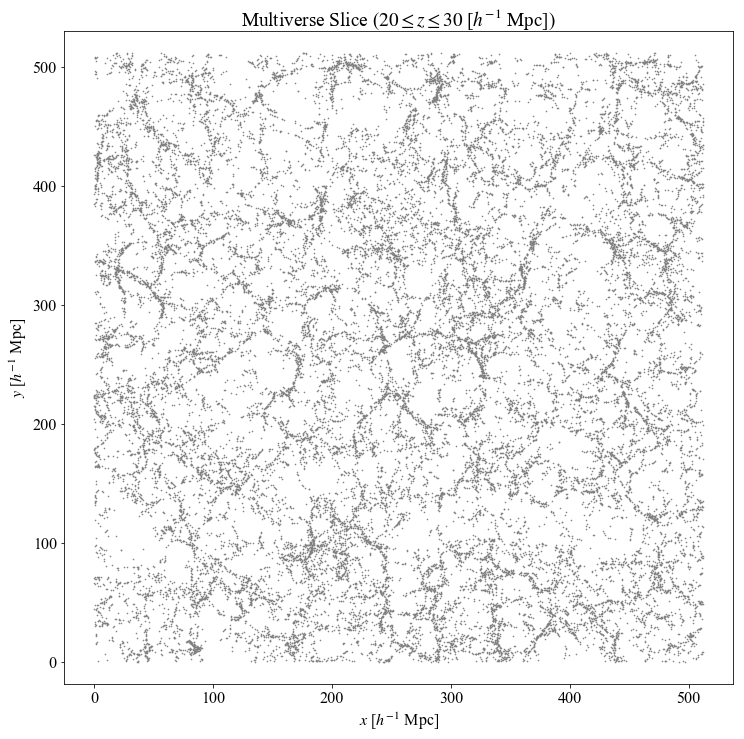

29

In [12]:
pdslice = haloslice.select('px','py').toPandas()

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(12,12))
plt.axes().set_aspect('equal','datalim')
plt.title(r'Multiverse Slice ($20 \leq z \leq 30$ [$h^{-1}$ Mpc])')
plt.xlabel(r'$x$ [$h^{-1}$ Mpc]')
plt.ylabel(r'$y$ [$h^{-1}$ Mpc]')
plt.scatter(pdslice.px.values,pdslice.py.values,s=1.5,marker=".",color='grey')
plt.savefig('slice.png')
plt.savefig('slice.pdf')
plt.show()

gc.collect()

## Generate cKDtree

In [13]:
halodf.select('px','py','pz').show(5)

+---------+---------+---------+
|       px|       py|       pz|
+---------+---------+---------+
|354.43866|154.60768|  94.1472|
|252.91493|177.28673| 465.8624|
|280.70523|317.62027| 42.28002|
|55.698288|249.97823|171.45457|
| 296.5703|189.49837|190.89578|
+---------+---------+---------+
only showing top 5 rows



* For using `cKDTree` from `scipy`, let's make a `pandas dataframe`; Any tree for Spark/DataFrame?

In [14]:
%%time

hpdf = halodf.select('px','py','pz').toPandas()
iddf = halodf.select('id').toPandas()

# For a small testing sample, generate KDTree for the slice 
#gpdf = galslice.select('px','py','pz').toPandas()
#iddf = galslice.select('galid').toPandas()

CPU times: user 11.7 s, sys: 896 ms, total: 12.6 s
Wall time: 13.3 s


In [15]:
%time hpdf.describe()

CPU times: user 175 ms, sys: 18.8 ms, total: 194 ms
Wall time: 192 ms


,px,py,pz
count,1.569696e+06,1.569696e+06,1.569696e+06
mean,2.561214e+02,2.561036e+02,2.571962e+02
std,1.480517e+02,1.481337e+02,1.484334e+02
min,3.290000e-04,2.680000e-04,1.710000e-04
25%,1.276228e+02,1.274953e+02,1.293816e+02
50%,2.565051e+02,2.575892e+02,2.574596e+02
75%,3.845949e+02,3.842360e+02,3.862653e+02
max,5.119999e+02,5.119997e+02,5.119999e+02


In [16]:
%time iddf.describe()

CPU times: user 50.8 ms, sys: 4.96 ms, total: 55.8 ms
Wall time: 54.1 ms


,id
count,1.569696e+06
mean,5.585057e+06
std,3.482207e+06
min,1.000000e+00
25%,2.588437e+06
50%,5.395248e+06
75%,8.196702e+06
max,1.244550e+07


In [17]:
sys.getsizeof(hpdf)

37672808

In [18]:
%time hptree = cKDTree(hpdf[['px','py','pz']])

CPU times: user 1.39 s, sys: 30.4 ms, total: 1.42 s
Wall time: 1.42 s


In [19]:
sys.getsizeof(hptree)

208

> Even we have 18 millions galaxies, their cKDTree size is super small. But we need to `collect` positions of `(px, py, pz)` to a dataframe `hpdf` (38MB) as an input for generating the `cKDTree`. Any way to directly generate the `cKDTree` from the spark/dataframe `halodf` with bypassing the `hpdf`?

## Generate edges in the format of spark/dataframe

In [20]:
gc.collect()

212

* ####  Broadcasting the cKDTree as `bcastTree` and test it

In [21]:
# broadcast kdtree
bcastTree = sc.broadcast(hptree)

In [22]:
# broadcast linklen
linklen = 1.6
bcastLinkLen = sc.broadcast(linklen) 

In [23]:
bcastID = sc.broadcast(iddf)

In [24]:
hpdf.loc[4,['px','py','pz']]


px    296.570312
py    189.498367
pz    190.895782
Name: 4, dtype: float64

In [25]:
dummy, inow = bcastTree.value.query(hpdf.loc[4,['px','py','pz']], k=[2,3,4])

In [26]:
print dummy

[0.71141554 1.09034328 1.56257543]


In [27]:
print inow

[1537127 1477414 1336007]


In [28]:
#bcastID.value.loc[inow[0]]
bcastID.value.loc[inow]

,id
1537127,2557651
1477414,2551647
1336007,2565103


In [29]:
print type(inow[0].item())

<type 'int'>


In [30]:
bcastLinkLen.value

1.6

* Define a UDF to get neighbors for each galaxy 

> Most `pandas` results are `numpy` formatted. Hence, we need to frequently call `.itmem()` to match the output format with `spark/dataframe` types. 

In [31]:
def getNeighbors(px,py,pz,curlinklen, curtree, curgalid):
    lengcut = curlinklen.value
    
    neighborlists = []
    inearest=2 # this is the first nearest neighbor in kdtree 
    
    dummy, inow = curtree.value.query([px,py,pz],k=[inearest])
    
    while (dummy[0] <= lengcut):
            
            neighborlists.append(curgalid.value.loc[inow[0]].item())
            inearest = inearest + 1 # the next nearest one 
            dummy, inow = curtree.value.query([px,py,pz],k=[inearest])
    
    return neighborlists

In [32]:
tmpout = getNeighbors(772.436096,777.702393,26.309305,bcastLinkLen,bcastTree,bcastID)

In [33]:
type(tmpout)

list

In [34]:
tmpout

[]

In [35]:
from functools import partial
getNeighborUDF = F.udf(partial(getNeighbors, curlinklen = bcastLinkLen, curtree = bcastTree, curgalid = bcastID),\
                T.ArrayType(T.IntegerType()))

In [36]:
halodf.show(5,truncate=True)

+--------+---------+---------+---------+-------------+
|      id|       px|       py|       pz|     halomass|
+--------+---------+---------+---------+-------------+
| 4781336|354.43866|154.60768|  94.1472|4.73930012E14|
|10825298|252.91493|177.28673| 465.8624|1.16470999E14|
| 9620325|280.70523|317.62027| 42.28002|3.15253015E14|
| 2491387|55.698288|249.97823|171.45457| 6.6380901E13|
| 5023833| 296.5703|189.49837|190.89578|3.57449995E14|
+--------+---------+---------+---------+-------------+
only showing top 5 rows



In [37]:
%time neighbordf = halodf.withColumn('neighbors',getNeighborUDF('px','py','pz'))
#%time neighbordf = galslice.withColumn('neighbors',getNeighborUDF('px','py','pz'))

CPU times: user 1.93 ms, sys: 1.29 ms, total: 3.22 ms
Wall time: 16.5 ms


In [38]:
%time neighbordf.select('id','neighbors').show(20,truncate=True)

+--------+--------------------+
|      id|           neighbors|
+--------+--------------------+
| 4781336|[4787244, 4790959...|
|10825298| [10827346, 8197636]|
| 9620325|    [9640517, 96749]|
| 2491387|                  []|
| 5023833|[2557651, 2551647...|
| 7610950|                  []|
| 2833846|           [2835361]|
|10479108|[10522511, 10526845]|
|10546077|[10592992, 105837...|
| 3283075|           [3283259]|
| 9671918|[9714987, 9677175...|
| 9677889|  [9683747, 9723357]|
| 2440140|                  []|
| 2491063|  [2494199, 2528358]|
|10072547|    [385054, 390626]|
| 7811283|[7838291, 7813812...|
| 1001911|                  []|
| 2288012|  [2295841, 2295460]|
| 7463752|                  []|
| 5125996|  [2658965, 5140028]|
+--------+--------------------+
only showing top 20 rows

CPU times: user 5.36 ms, sys: 3.42 ms, total: 8.78 ms
Wall time: 17.4 s


In [39]:
neighbordf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- halomass: float (nullable = true)
 |-- neighbors: array (nullable = true)
 |    |-- element: integer (containsNull = true)



* #### `explode` the neighbors to get an edge dataframe `edgedf`

In [40]:
#%time edgelist = neighbordf.select('id',F.explode('neighbors').alias('dst')).collect()
%time edgelist = neighbordf.select('id',F.explode('neighbors').alias('dst'))

CPU times: user 1.55 ms, sys: 944 µs, total: 2.5 ms
Wall time: 10.3 ms


In [41]:
"""
edge_schema = T.StructType([\
                           T.StructField('src', T.IntegerType(), False),\
                           T.StructField('dst', T.IntegerType(), False),\
                          ])
edgedf = sqlsc.createDataFrame(edgelist,schema=edge_schema) 
"""
edgedf = edgelist.select(F.col("id").alias("src"),"dst")

In [42]:
edgedf.printSchema()

root
 |-- src: integer (nullable = true)
 |-- dst: integer (nullable = true)



In [43]:
#edgedf.cache().show(30,truncate=True)
%time edgedf.cache()

CPU times: user 672 µs, sys: 777 µs, total: 1.45 ms
Wall time: 25.5 ms


DataFrame[src: int, dst: int]

* #### Define a graphframe `g` and do the graph caculations using `halodf` (vertices) and `edgedf` (edges)

In [44]:
halodf.show(5,truncate=True)

+--------+---------+---------+---------+-------------+
|      id|       px|       py|       pz|     halomass|
+--------+---------+---------+---------+-------------+
| 4781336|354.43866|154.60768|  94.1472|4.73930012E14|
|10825298|252.91493|177.28673| 465.8624|1.16470999E14|
| 9620325|280.70523|317.62027| 42.28002|3.15253015E14|
| 2491387|55.698288|249.97823|171.45457| 6.6380901E13|
| 5023833| 296.5703|189.49837|190.89578|3.57449995E14|
+--------+---------+---------+---------+-------------+
only showing top 5 rows



In [45]:
from graphframes import *

In [46]:
%time g = GraphFrame(halodf,edgedf)
#g = GraphFrame(galslice,edgedf)

CPU times: user 1.84 ms, sys: 1.15 ms, total: 2.98 ms
Wall time: 22.4 ms


In [47]:
g.vertices.show(2, truncate=True)

+--------+---------+---------+--------+-------------+
|      id|       px|       py|      pz|     halomass|
+--------+---------+---------+--------+-------------+
| 4781336|354.43866|154.60768| 94.1472|4.73930012E14|
|10825298|252.91493|177.28673|465.8624|1.16470999E14|
+--------+---------+---------+--------+-------------+
only showing top 2 rows



In [48]:
g.edges.show(2, truncate=True)

+-------+-------+
|    src|    dst|
+-------+-------+
|4781336|4787244|
|4781336|4790959|
+-------+-------+
only showing top 2 rows



In [49]:
edgedf.filter(edgedf['dst'] == 2557651).show()

+-------+-------+
|    src|    dst|
+-------+-------+
|5023833|2557651|
|2551647|2557651|
|2554210|2557651|
+-------+-------+



In [50]:
edgedf.filter(edgedf['src'] == 2557651).orderBy(edgedf.dst.asc()).show()

+-------+-------+
|    src|    dst|
+-------+-------+
|2557651|2551647|
|2557651|2554210|
|2557651|5023833|
+-------+-------+



* #### Now, getting the number of trianges and neighbors
> `g.triangleCount()` returns a dataframe of `g.vertices` + `count`. `g.inDegrees` returns a dataframe of `id` + `inDegree` columns. Hence, `join` the two output dataframes to a `resultdf`, which has all information I need. 

In [51]:
resultdf = g.triangleCount().join(g.inDegrees, "id")

In [52]:
resultdf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- halomass: float (nullable = true)
 |-- inDegree: integer (nullable = false)



In [53]:
resultdf.select('id','inDegree','count').orderBy('id').show(5)

+---+--------+-----+
| id|inDegree|count|
+---+--------+-----+
| 11|       2|    1|
| 22|       2|    1|
| 25|       6|   13|
| 32|       3|    3|
| 38|       1|    0|
+---+--------+-----+
only showing top 5 rows



In [54]:
%%time
tmp = g.connectedComponents().select("id","component")
finalresult = resultdf.join(tmp,"id")
finalresult.printSchema()

root
 |-- id: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- halomass: float (nullable = true)
 |-- inDegree: integer (nullable = false)
 |-- component: long (nullable = true)

CPU times: user 6.69 ms, sys: 3.16 ms, total: 9.85 ms
Wall time: 47.1 s


In [55]:
%time finalresult.select("id","inDegree","count","component").orderBy("id",ascending=False).show(5)

+--------+--------+-----+---------+
|      id|inDegree|count|component|
+--------+--------+-----+---------+
|12445396|       1|    0|    33439|
|12445394|       2|    1|    13534|
|12445391|       1|    0|    13111|
|12445389|       1|    0|    19721|
|12445339|       1|    0|    25666|
+--------+--------+-----+---------+
only showing top 5 rows

CPU times: user 5.77 ms, sys: 2.58 ms, total: 8.35 ms
Wall time: 8.03 s


In [56]:
%time resultpd = finalresult.toPandas()

CPU times: user 5.26 s, sys: 446 ms, total: 5.7 s
Wall time: 12.7 s


In [57]:
resultpd.describe()

,id,count,px,py,pz,halomass,inDegree,component
count,1.010967e+06,1.010967e+06,1.010967e+06,1.010967e+06,1.010967e+06,1.010967e+06,1.010967e+06,1.010967e+06
mean,5.592082e+06,9.954479e-01,2.560652e+02,2.565260e+02,2.576536e+02,2.713015e+12,1.961811e+00,4.726714e+06
std,3.479327e+06,2.220311e+00,1.479785e+02,1.481431e+02,1.483949e+02,1.480570e+13,1.258716e+00,3.439462e+06
min,1.100000e+01,0.000000e+00,3.290000e-04,2.680000e-04,8.230000e-04,2.706110e+11,1.000000e+00,1.100000e+01
25%,2.595442e+06,0.000000e+00,1.275807e+02,1.278598e+02,1.301109e+02,3.788560e+11,1.000000e+00,1.005485e+06
50%,5.398718e+06,0.000000e+00,2.566761e+02,2.588362e+02,2.580119e+02,6.043650e+11,2.000000e+00,4.832669e+06
75%,8.199476e+06,1.000000e+00,3.844503e+02,3.846434e+02,3.869075e+02,1.371100e+12,2.000000e+00,7.668142e+06
max,1.244540e+07,6.000000e+01,5.119997e+02,5.119997e+02,5.119999e+02,1.901580e+15,1.600000e+01,1.244465e+07


In [58]:
resultpd.columns = ['id','tcount','px','py','pz','halomass','inDegree','component']
resultpd.head()

,id,tcount,px,py,pz,halomass,inDegree,component
0,148,3,127.042709,142.383774,0.813006,3.517950e+11,3,148
1,1580,0,502.016724,96.430573,2.936783,1.813100e+12,2,1265
2,3175,0,311.646149,151.653107,3.373718,7.126100e+11,1,1934
3,4101,5,213.976089,47.416313,2.961219,3.788560e+11,4,2423
4,4818,0,383.114685,277.069641,3.056836,1.208730e+12,1,4818


In [59]:
resultpd["component"].value_counts()

922448      207
126448      179
252770      172
125524      144
545329      139
5081968     135
5377081     127
959617      125
167872      122
3095974     119
586598      116
1007812     114
679273      107
752142      106
84487       102
3242694     101
960261       99
8218236      99
2207210      99
135439       95
379902       95
669846       94
264120       92
4624651      92
2756561      92
963179       91
501633       90
462480       89
752354       88
251168       87
           ... 
901891        2
7819222       2
10617595      2
7478008       2
2251504       2
7783271       2
9628390       2
2570201       2
5450462       2
5356454       2
2249822       2
5053208       2
2949915       2
7156509       2
5198673       2
8299375       2
3093341       2
5192540       2
987993        2
503754        2
5718871       2
7310154       2
10190354      2
2594765       2
2892607       2
471897        2
457568        2
7082809       2
7825363       2
6141          2
Name: component, Length:

In [60]:
temp = np.double(finalresult.select("component").distinct().count())

In [61]:
temp

285174.0

In [71]:
pscomp = resultpd["component"].value_counts()

In [77]:
len(pscomp[pscomp >= 2])

285174

In [78]:
len(pscomp[pscomp >= 3])

139148

In [79]:
len(pscomp[pscomp == 2])

146026

In [62]:
totalvertices = np.double(halodf.count())

In [63]:
len(resultpd.index)

1010967

In [64]:
np.double(resultpd["component"].value_counts().values[0])/totalvertices

0.00013187266833832793

In [65]:
np.double(resultpd["component"].value_counts().values[1])/totalvertices

0.00011403481948096956

In [66]:
resultpd['lcc'] = resultpd.apply(lambda row: np.double(row.tcount)*2.0/(np.double(row.inDegree)*(np.double(row.inDegree)-1.0)) , axis=1)

/home/shong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [67]:
resultpd.head(10)

,id,tcount,px,py,pz,halomass,inDegree,component,lcc
0,148,3,127.042709,142.383774,0.813006,3.517950e+11,3,148,1.000000
1,1580,0,502.016724,96.430573,2.936783,1.813100e+12,2,1265,0.000000
2,3175,0,311.646149,151.653107,3.373718,7.126100e+11,1,1934,NaN
3,4101,5,213.976089,47.416313,2.961219,3.788560e+11,4,2423,0.833333
4,4818,0,383.114685,277.069641,3.056836,1.208730e+12,1,4818,NaN
5,5300,0,196.867310,460.978119,3.413329,9.742000e+11,2,5300,0.000000
6,5518,10,89.410736,57.322941,3.528389,6.945690e+11,6,3608,0.666667
7,6336,1,405.125549,400.201965,1.972374,5.791080e+12,2,6062,1.000000
8,6620,0,183.267868,102.467026,2.585900,4.871000e+11,2,5358,0.000000
9,7754,2,50.429317,194.791672,2.020648,3.788560e+11,4,860,0.333333


In [68]:
# local clustering coefficient
np.nanmean(resultpd.lcc.values)

0.5643414150016538

In [69]:
# total counts of triples
#resultpd['inDegree'].apply(lambda x: np.double(x*(x-1))).sum()
# triangle sum
#np.double(resultpd['tcount'].sum())

final_transitivity = 2.0*np.double(resultpd['tcount'].sum())/resultpd['inDegree'].apply(lambda x: np.double(x*(x-1))).sum()

In [70]:
final_transitivity

0.5735378095610436